## GRU Network Predictions

In [ ]:
##create the classes and prepare the data
import os, sys

sys.path.append(os.path.abspath("../data_set_generator"))
sys.path.append(os.path.abspath("../network_training"))
sys.path.append(os.path.abspath("../data_preprocessing"))
sys.path.append(os.path.abspath("../data"))


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
import keras
from keras import optimizers
from keras.models import Sequential
from data_set_generator.bike_prediction import DataGenerator
from data_set_generator.data_config import BikeDataConfig
from network_training.network_generator import NetworkGenerator
from network_training.callbacks import Callbacks

classes = 8
conf = BikeDataConfig(bikes_path = './/../data//bikes.csv', weather_path = './/../data//weather.csv', highest_class = classes)
FFN_logs_base_dir='./Modellcheckpoints/Gru/'
os.makedirs(FFN_logs_base_dir, exist_ok=True)
FFN_log_dir=os.path.join(FFN_logs_base_dir, '_GRU.h5')
callbacks = Callbacks(filepath = FFN_log_dir)


batch_size = 256
input_dims = 11
output_dims = classes + 1 
sequence_length = 3
adam_optimizer = optimizers.Adam(learning_rate = 1e-4, beta_1=1- 1e-4, amsgrad = True)
sgd_optimizer = optimizers.SGD(learning_rate = 1e-2,  momentum = 0.9, nesterov = True)

network_gen = NetworkGenerator(data_generator = conf.d_gen, callbacks = callbacks, history_length = sequence_length)

## Create Batch Generators

In [ ]:
train_data_generator = network_gen.batch_generator(batch_size = batch_size, 
                             sequence_length = network_gen.history_length, 
                             x_data = network_gen.data_gen.train_list_x,
                             y_data = network_gen.data_gen.train_list_y,
                             min_index = 0,
                             num_x_signals = input_dims,
                             num_y_signals = output_dims,
                             random = False)

val_data_generator = network_gen.batch_generator(batch_size = batch_size, 
                             sequence_length = network_gen.history_length, 
                             x_data = network_gen.data_gen.vali_list_x,
                             y_data = network_gen.data_gen.vali_list_y,
                             min_index = 0,
                             num_x_signals = input_dims,
                             num_y_signals = output_dims,
                             all_data = True)

test_data_generator = network_gen.batch_generator(batch_size = batch_size, 
                             sequence_length = network_gen.history_length, 
                             x_data = network_gen.data_gen.test_list_x,
                             y_data = network_gen.data_gen.test_list_y,
                             min_index = 0,
                             num_x_signals = input_dims,
                             num_y_signals = output_dims,
                             all_data = True)

x_batch, y_batch = next(train_data_generator)
print(x_batch)
print(y_batch)

[[[ 0.77469835  0.54316378  0.         ...  1.         -0.06540313
   -0.99785892]
  [ 0.77469835  0.54316378  0.         ...  1.         -0.04361939
   -0.99904822]
  [ 0.77469835  0.54316378  0.         ...  1.         -0.02181489
   -0.99976203]]

 [[ 0.77468936  0.54317987  0.         ...  1.         -0.44228869
   -0.89687274]
  [ 0.77468936  0.54317987  0.         ...  1.         -0.42261826
   -0.90630779]
  [ 0.77468936  0.54317987  0.         ...  1.         -0.40274669
   -0.91531148]]

 [[ 0.77468837  0.54314303  0.         ...  1.          0.99144486
   -0.13052619]
  [ 0.77468837  0.54314303  0.         ...  1.          0.99405634
   -0.10886687]
  [ 0.77468837  0.54314303  0.         ...  1.          0.9961947
   -0.08715574]]

 ...

 [[ 0.77461529  0.54307175  0.         ...  1.          0.99976203
    0.02181489]
  [ 0.77461529  0.54307175  0.         ...  1.          0.99904822
    0.04361939]
  [ 0.77461529  0.54307175  0.         ...  1.          0.99785892
    0.065

## Define and Generate a GRU Network

In [8]:
gru = Sequential()
gru.add(keras.layers.GRU(input_dims,
                     recurrent_dropout=0.5, 
                     return_sequences=True, 
                     input_shape = ( x_batch.shape[1], x_batch.shape[2] )  )
         )

gru.add(keras.layers.GRU(4*input_dims+1,
                      dropout=0.1,
                      recurrent_dropout=0.5,
                      activation = 'relu',
                      return_sequences=True)
          )

gru.add(keras.layers.GRU(4*input_dims+1,
                      dropout=0.1,
                      recurrent_dropout=0.5, 
                      activation = 'relu'
                      )
          )

gru.add(keras.layers.Dense(output_dims, activation = 'softmax'))
gru.summary()

network_gen.register_network(gru)
network_gen.model.compile(optimizer = sgd_optimizer, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
results = network_gen.train_network(validation_data = val_data_generator, epochs = 25, train_data = train_data_generator)

/home/flo/python_environments/ml/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 3, 11)          │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 3, 45)          │         7,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 45)             │        12,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           414 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,456 (83.81 KB)

 Trainable params: 21,456 (83.81 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
1282/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.3740 - loss: 1.6587

/home/flo/python_projects/bike_forecast_kl/network_training/network_generator.py:91: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  y_batch[i][int(y_data.iloc[j])] = 1


1283/1283 ━━━━━━━━━━━━━━━━━━━━ 238s 181ms/step - categorical_accuracy: 0.3743 - loss: 1.6579 - val_categorical_accuracy: 0.8421 - val_loss: 0.6067
Epoch 2/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.8433 - loss: 0.5940

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 58s 45ms/step - categorical_accuracy: 0.8433 - loss: 0.5940 - val_categorical_accuracy: 0.8581 - val_loss: 0.5345
Epoch 3/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.8750 - loss: 0.4980

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - categorical_accuracy: 0.8751 - loss: 0.4980 - val_categorical_accuracy: 0.8789 - val_loss: 0.5156
Epoch 4/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.8896 - loss: 0.4570

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 59s 46ms/step - categorical_accuracy: 0.8896 - loss: 0.4570 - val_categorical_accuracy: 0.8836 - val_loss: 0.4918
Epoch 5/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.8998 - loss: 0.4248

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 60s 47ms/step - categorical_accuracy: 0.8998 - loss: 0.4248 - val_categorical_accuracy: 0.8846 - val_loss: 0.4802
Epoch 6/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 56s 44ms/step - categorical_accuracy: 0.9051 - loss: 0.4121 - val_categorical_accuracy: 0.8848 - val_loss: 0.4805
Epoch 7/25
1282/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.9089 - loss: 0.3977

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 59s 46ms/step - categorical_accuracy: 0.9089 - loss: 0.3977 - val_categorical_accuracy: 0.8862 - val_loss: 0.4711
Epoch 8/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.9122 - loss: 0.3863

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - categorical_accuracy: 0.9122 - loss: 0.3863 - val_categorical_accuracy: 0.8859 - val_loss: 0.4663
Epoch 9/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 58s 45ms/step - categorical_accuracy: 0.9147 - loss: 0.3778 - val_categorical_accuracy: 0.8867 - val_loss: 0.4694
Epoch 10/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.9166 - loss: 0.3723

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 59s 46ms/step - categorical_accuracy: 0.9166 - loss: 0.3723 - val_categorical_accuracy: 0.8866 - val_loss: 0.4595
Epoch 11/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 59s 46ms/step - categorical_accuracy: 0.9183 - loss: 0.3665 - val_categorical_accuracy: 0.8855 - val_loss: 0.4657
Epoch 12/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.9178 - loss: 0.3662

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 57s 45ms/step - categorical_accuracy: 0.9178 - loss: 0.3662 - val_categorical_accuracy: 0.8864 - val_loss: 0.4560
Epoch 13/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 58s 45ms/step - categorical_accuracy: 0.9184 - loss: 0.3657 - val_categorical_accuracy: 0.8867 - val_loss: 0.4583
Epoch 14/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 58s 45ms/step - categorical_accuracy: 0.9196 - loss: 0.3599 - val_categorical_accuracy: 0.8862 - val_loss: 0.4564
Epoch 15/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 56s 44ms/step - categorical_accuracy: 0.9208 - loss: 0.3548 - val_categorical_accuracy: 0.8869 - val_loss: 0.4562
Epoch 16/25
1282/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.9191 - loss: 0.3593

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 59s 46ms/step - categorical_accuracy: 0.9191 - loss: 0.3593 - val_categorical_accuracy: 0.8864 - val_loss: 0.4516
Epoch 17/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - categorical_accuracy: 0.9204 - loss: 0.3540 - val_categorical_accuracy: 0.8858 - val_loss: 0.4550
Epoch 18/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - categorical_accuracy: 0.9205 - loss: 0.3524 - val_categorical_accuracy: 0.8859 - val_loss: 0.4546
Epoch 19/25
1282/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.9205 - loss: 0.3513

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 58s 45ms/step - categorical_accuracy: 0.9205 - loss: 0.3513 - val_categorical_accuracy: 0.8860 - val_loss: 0.4514
Epoch 20/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 58s 45ms/step - categorical_accuracy: 0.9205 - loss: 0.3541 - val_categorical_accuracy: 0.8859 - val_loss: 0.4582
Epoch 21/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 58s 45ms/step - categorical_accuracy: 0.9214 - loss: 0.3494 - val_categorical_accuracy: 0.8872 - val_loss: 0.4544
Epoch 22/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - categorical_accuracy: 0.9222 - loss: 0.3472

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 58s 45ms/step - categorical_accuracy: 0.9222 - loss: 0.3472 - val_categorical_accuracy: 0.8863 - val_loss: 0.4491
Epoch 23/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 58s 45ms/step - categorical_accuracy: 0.9215 - loss: 0.3465 - val_categorical_accuracy: 0.8862 - val_loss: 0.4547
Epoch 24/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 59s 46ms/step - categorical_accuracy: 0.9206 - loss: 0.3495 - val_categorical_accuracy: 0.8859 - val_loss: 0.4542
Epoch 25/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 58s 45ms/step - categorical_accuracy: 0.9206 - loss: 0.3514 - val_categorical_accuracy: 0.8861 - val_loss: 0.4496


## Print Training Results

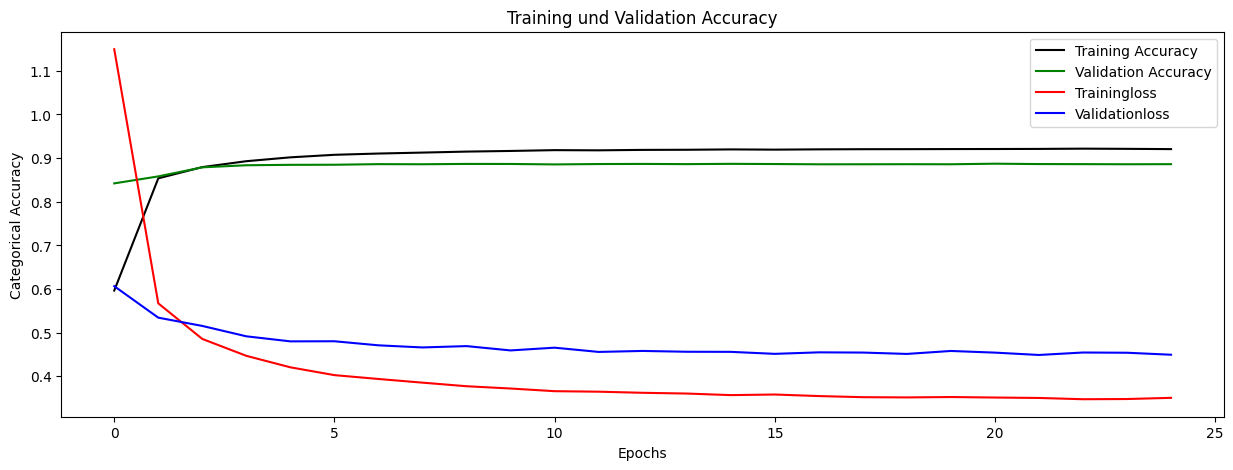

In [9]:
network_gen.print_training(results)

## Test Network and Create Metrics

In [10]:
x_batch, y_batch = next(test_data_generator)
network_gen.test_predictions(network_gen.model, x_batch, y_batch, True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 3, 11)          │           792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 3, 45)          │         7,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 45)             │        12,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           414 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,914 (167.64 KB)

 Trainable params: 21,456 (83.81 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,458 (83.82 KB)

17597/17597 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - categorical_accuracy: 0.8989 - loss: 0.4081
17597/17597 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step
Confusion Matrix
[[ 84110   3588    514     99     26     10      4      1      3]
 [  3528  68092   3479    536     93     25     10      2      0]
 [   419   3384  55620   3242    487     82     20      6      4]
 [   105    487   3110  47286   2700    473    105     35     32]
 [    56    101    360   2588  39385   2681    417     81     80]
 [    18     52     83    373   2477  30158   3352    385    156]
 [    28     33     56    107    368   2229  25631   1969    504]
 [     6      9     16     33     65    293   2101  24635   2124]
 [    38     49     29     36     41     98    428   2184 135453]]
Klassifikations Report
0.9063850267189739
Akkuratheit der Klassifikation
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     88355
           1       0.90      0.90      0.90     75765
           2  